# Homework 2: DDPM

## Section A

In this section, we will implement DDPM (**Denoising Diffusion Probabilistic Models**) on a simple 1D Mixture of Gaussians Model.

Note that GPUs will not help in any part except the final section with the generation of images (everything else runs in less than a second), so it is recommended to run this part of the homework on a local CPU.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import itertools
from tqdm.auto import tqdm

A Gaussian Mixture Model is a distribution that is the combination of several Gaussian distributions, such as the following:

$$
X | Y \sim \mathcal{N}(\mu_1, \sigma_1 I)Y + \mathcal{N}(\mu_2, \sigma_2 I)(1 - Y)
$$

where $Y \sim \text{Ber}(p)$. In our case, $X \in \mathbb{R}^1$.

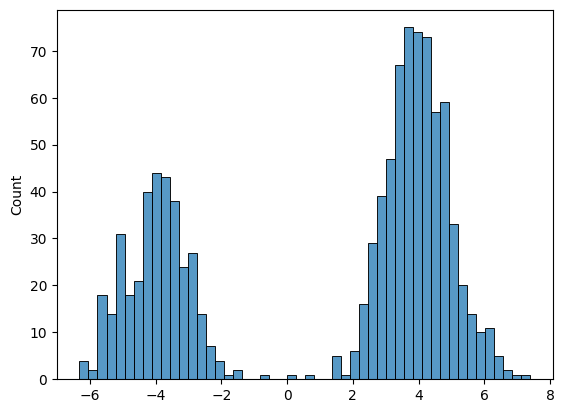

In [2]:
data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([1, 2])),
    torch.distributions.Normal(torch.tensor([-4., 4.]), torch.tensor([1., 1.]))
)

dataset = data_distribution.sample(torch.Size([1000, 1]))
sns.histplot(dataset[:, 0], bins=50)
plt.show()


In [3]:
# we will keep these parameters fixed throughout
TIME_STEPS = 250
BETA = 0.02
ALPHA = 1 - BETA
ALPHA_BAR = [ALPHA ** i for i in range(TIME_STEPS+1)]

Pay attention - beta is constant, hence $x_{t+1}$ is sampled from $q_t = \mathcal{N}(\sqrt{1-\beta}x_t, \sqrt{\beta})$

Implement the following functions to perform ddpm and restore the original given distribution. You can add any other functions required.

In [ ]:
def do_diffusion(data, steps=TIME_STEPS, beta=BETA):
    ''''
    perform diffusion following equation 2
    returns a list of q(x(t)) and x(t)
    starting from t=0 (i.e., the dataset)

    :param data: torch.Size([1000, 1])
    :return samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :return distributions: list of length TIME_STEPS+1 of Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) distributions
    '''


    distributions, samples = [None], [data]
    xt = data # = data_distribution.sample(torch.Size([1000, 1]))

    #### ADD YOUR CODE HERE ####

    beta_tensor = torch.tensor(beta)
    alpha_tensor = torch.tensor(1 - beta)
    sqrt_alpha = torch.sqrt(alpha_tensor)
    std = torch.sqrt(beta_tensor)

    for t in range(1, steps + 1):
        mean = sqrt_alpha * xt
        dist = torch.distributions.Normal(mean, std)
        xt = dist.rsample()

        distributions.append(dist)
        samples.append(xt)

    #### DONE WITH SOLUTION ####

    return distributions, samples

Sample and visualize realizations of the forward/diffusion process over time using samples from do_diffusion(dataset)

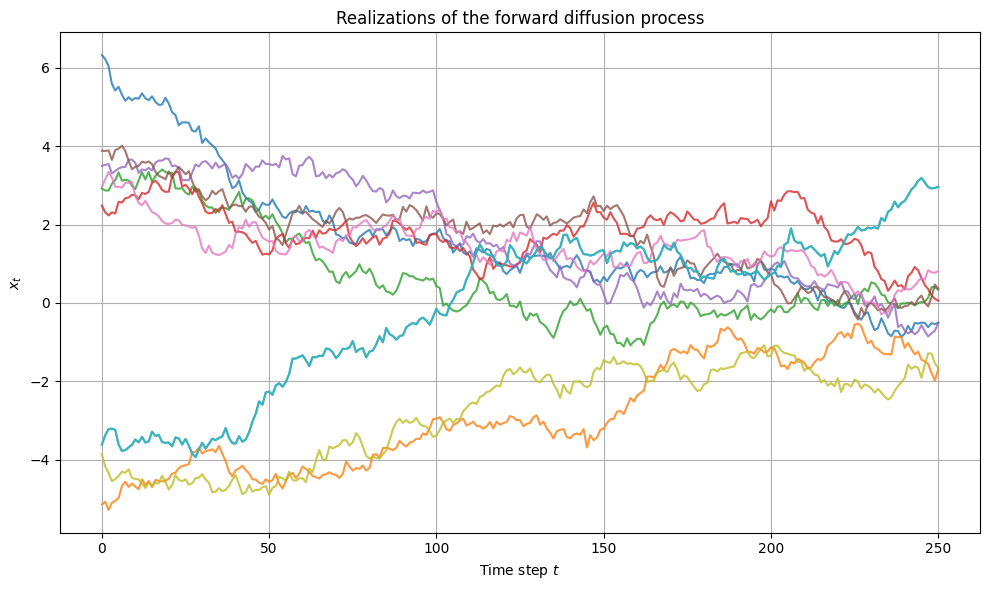

In [ ]:
_, samples = do_diffusion(dataset)

#### ADD YOUR CODE HERE ####

# Pick a few trajectories (indices of data points to track)
indices_to_track = torch.randint(0, dataset.shape[0], (10,))

# Create a figure
plt.figure(figsize=(10, 6))

# Plot each trajectory
for idx in indices_to_track:
    trajectory = [samples[t][idx].item() for t in range(len(samples))]
    plt.plot(range(len(samples)), trajectory, alpha=0.8)

plt.title("Realizations of the forward diffusion process")
plt.xlabel("Time step $t$")
plt.ylabel("$x_t$")
plt.grid(True)
plt.tight_layout()
plt.show()

#### DONE WITH SOLUTION ####

# Training
We first use the loss in Equation 3 in the paper without any of the optimizations presented later, which a play significant role for complex, real-world distributions.

Diffusion models are trained by first corrupting the training examples, then trying to reconstruct the cleaner examples from the noisy examples at each step of the corruption process. The loss is an upper bound on the negative log likelihood:

$L := \mathbb{E}_q\left[
-\log p(x_T)
-\sum_{t=1}^T \log\frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})}
\right]$

Where the generative model, also called reverse process, has form:

$p_\theta(x_{t-1}|x_t):=\mathcal{N}(x_{t-1} ; \mu_\theta(x_t,t), \Sigma_\theta(x_t, t))$

Note that we are training two neural networks, $\mu_\theta$ and $\Sigma_\theta$, which take as input a noisy sample $x_t$ and the step $t$, and try to predict the parameters of the distribution of the sample $x_{t-1}$ to which noise was added. Intuitively, we are training these networks to maximize the predicted probability of observing the uncorrputed example $x_{t-1}$ based on $x_t$ , i.e., the term $p_\theta(x_{t-1}\vert x_t)$ in the loss, for each diffusion step. Remember that $x_t$ was generated earlier from $x_{t-1}$ by adding noise; the networks have to learn to undo the noise. The other terms in the loss involving $q(x_t\vert x_{t-1})$ are not necessary to learn a good generative model, since they are constant, but are useful as a “frame of reference” to make a “perfect” generative model achieve a loss of 0.

You should implement the loss in the function below. This function requires the entire diffusion trajectory for the training samples, as well as the two neural networks that define the inverse process:

In [ ]:
def compute_loss_equation3(forward_distributions, forward_samples, mean_model, var_model):
    """
    Compute the loss in equation 3
    forward = q , reverse = p

    :param forward_distributions: list of length TIME_STEPS+1 of Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) distributions
    :param forward_samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :param mean_model: torch.nn.Module
    :param var_model: torch.nn.Module
    :return: averaged loss over total TIME_STEPS
    """
    #### ADD YOUR CODE HERE ####

    T           = TIME_STEPS        # nombre total de pas
    device      = forward_samples[0].device
    batch_shape = forward_samples[0].shape         # (batch, 1)

    # ─────────────────────────── prior term  −log p(x_T)  ──────────────────────────
    x_T = forward_samples[-1]                      # (batch, 1)
    prior = torch.distributions.Normal(
        torch.zeros(1, device=device),
        torch.ones (1, device=device)
    )
    loss_prior = -prior.log_prob(x_T)              # (batch, 1)

    # ─────────────────────────── reverse / forward ratio  ─────────────────────────
    kl_terms = []
    for t in range(1, T + 1):
        x_t    = forward_samples[t]      # (batch, 1)
        x_prev = forward_samples[t - 1]  # (batch, 1)

        # 1. paramètres du noyau inverse pθ(x_{t-1}|x_t)
        t_tensor = torch.full_like(x_t, t, dtype=torch.float)  # ensure shape (batch, 1)
        μ_theta = mean_model(x_t, t_tensor)
        log_sigma_theta = var_model(x_t, t_tensor)

        σ_theta      = torch.exp(0.5 * log_sigma_theta)     # (batch, 1)
        p_theta_dist = torch.distributions.Normal(μ_theta, σ_theta)

        log_p = p_theta_dist.log_prob(x_prev)           # (batch, 1)

        # 2. noyau forward q(x_t|x_{t-1}) déjà stocké
        q_dist = forward_distributions[t]               # Normal(·)
        log_q = q_dist.log_prob(x_t)                    # (batch, 1)

        # 3. terme   −log (p/q)  =  −(log p − log q)
        kl_terms.append(-(log_p - log_q))               # (batch, 1)

    kl_stack = torch.stack(kl_terms, dim=0)             # (T, batch, 1)

    # ─────────────────────────── agrégation & normalisation ───────────────────────
    loss_per_sample = loss_prior + kl_stack.sum(dim=0)  # (batch, 1)
    # moyenne sur le batch puis sur le nombre de pas
    loss = loss_per_sample.mean() / T

    return loss

    #### DONE WITH SOLUTION ####


We also implement and use the loss in Equation 12 in the paper with the suggested optimizations presented.

In [ ]:
def compute_loss_equation12(forward_samples, noise_model):
    """
    Compute the loss in equation 12
    forward = q , reverse = p
    :param forward_samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :param noise_model: torch.nn.Module
    :return: averaged loss over TIME_STEPS
    """
    #### ADD YOUR CODE HERE ####

    x0 = forward_samples[0]               # (N, 1)
    N = x0.shape[0]
    device = x0.device

    losses = []

    for t in range(1, TIME_STEPS + 1):
        t_tensor = torch.full((N, 1), t, dtype=torch.long, device=device)

        alpha_t = ALPHA
        beta_t = BETA
        sigma_t2 = beta_t                 # σ_t² = β_t si forward isotrope
        alpha_bar_t = ALPHA_BAR[t]       # \bar{\alpha}_t

        # 1. Sample epsilon ~ N(0, I)
        epsilon = torch.randn_like(x0)

        # 2. Compute x_t from x_0 and epsilon using forward eq.
        sqrt_ab = torch.sqrt(torch.tensor(alpha_bar_t, device=device))
        sqrt_one_minus_ab = torch.sqrt(torch.tensor(1.0 - alpha_bar_t, device=device))
        x_t = sqrt_ab * x0 + sqrt_one_minus_ab * epsilon

        # 3. Predict epsilon_theta(x_t, t)
        epsilon_theta = noise_model(x_t, t_tensor)

        # 4. Compute scaling coefficient
        coeff = (beta_t**2) / (2 * sigma_t2 * alpha_t * (1 - alpha_bar_t))

        # 5. Squared error
        mse = (epsilon - epsilon_theta).pow(2).mean()

        losses.append(coeff * mse)

    return torch.stack(losses).mean()

    #### DONE WITH SOLUTION ####


In [ ]:
def compute_loss(equation, forward_distributions, forward_samples, mean_model=None, var_model=None, noise_model=None):
    """
    Compute the loss according to the given equation (just a wrapper)
    :param equation: int
    :param forward_distributions: list of length TIME_STEPS+1 of Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) distributions
    :param forward_samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :param mean_model: Optional(torch.nn.Module)=None
    :param var_model: Optional(torch.nn.Module)=None
    :param noise_model: Optional(torch.nn.Module)=None
    :return: averaged loss over TIME_STEPS
    """
    #### ADD YOUR CODE HERE ####

    if equation == 3:
        if mean_model is None or var_model is None:
            raise ValueError("Equation 3 requires mean_model and var_model.")
        return compute_loss_equation3(forward_distributions,
                                      forward_samples,
                                      mean_model,
                                      var_model)

    elif equation == 12:
        if noise_model is None:
            raise ValueError("Equation 12 requires noise_model.")
        return compute_loss_equation12(forward_samples, noise_model)

    else:
        raise NotImplementedError(f"Equation {equation} not implemented (valid ones are 3 and 12).")



    #### DONE WITH SOLUTION ####

Now define three very simple neural networks to predict the mean/variance/noise, and an optimizer.

These networks take two inputs: the noisy sample $x_t$ and the normalized time-step t. The time-step is added as an additional column feature, and, since the input is also one-dimensional, the total input size is two.

When you are happy with your simple model architecure, show the training curve for both equations.

In [ ]:
#### ADD YOUR CODE HERE ####

import torch
import torch.nn as nn

# ────────────────── helper MLP (shared architecture) ──────────────────
class _TwoInputMLP(nn.Module):
    """
    Very small feed-forward net that takes:
      x_t : (batch, 1)
      t   : (batch, 1)  – already normalised in [0,1]
    Concatenates → (batch, 2) and returns a (batch, 1) output.
    """
    def __init__(self, out_activation=None, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1)
        )
        self.out_activation = out_activation or (lambda z: z)

    def forward(self, x_t, t_step):
        # t_step can be scalar int, vector int, or float in [0,1]
        if t_step.ndim == 0:                       # scalar → expand
            t_step = torch.full_like(x_t, t_step)
        t_norm = t_step.float() / TIME_STEPS       # normalise in [0,1]
        inp   = torch.cat([x_t, t_norm], dim=1)    # (batch, 2)
        return self.out_activation(self.net(inp))  # (batch, 1)


# ───────────────────── specialised heads ──────────────────────
class MeanNet(_TwoInputMLP):
    """Predicts μ_θ(x_t,t) (no constraint)."""
    pass

class VarNet(_TwoInputMLP):
    """Predicts log σ_θ²(x_t,t); positive variance enforced via Softplus."""
    def __init__(self, hidden=64):
        super().__init__(out_activation=lambda z: torch.log1p(torch.exp(z)),  # Softplus then log
                         hidden=hidden)

class NoiseNet(_TwoInputMLP):
    """Predicts ε_θ(x_t,t) (MSE target)."""
    pass


#### DONE WITH SOLUTION ####

In [ ]:
def train_loop(equation, dataset, optim, mean_model=None, var_model=None, noise_model=None):
    """
    Train the model
    :equation: which equation loss to train on
    :param dataset: torch.Size([1000, 1])
    :param mean_model: Optinal(torch.nn.Module) = None
    :param var_model: Optinal(torch.nn.Module) = None
    :param noise_model: Optinal(torch.nn.Module) = None
    :param optim: torch.optim
    :return: list of losses by epoch
    """
    loss_history = []
    bar = tqdm(range(300))
    #### ADD YOUR CODE HERE ####

    for epoch in bar:
        # 1. Forward diffusion process
        forward_dists, forward_samples = do_diffusion(dataset)

        # 2. Compute loss (according to chosen equation)
        loss = compute_loss(
            equation=equation,
            forward_distributions=forward_dists,
            forward_samples=forward_samples,
            mean_model=mean_model,
            var_model=var_model,
            noise_model=noise_model
        )

        # 3. Optimizer step
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 4. Log and update progress bar
        loss_val = loss.item()
        loss_history.append(loss_val)
        bar.set_description(f"Eq {equation} | Loss: {loss_val:.4f}")

    return loss_history


    #### DONE WITH SOLUTION ####

    return loss_history



Training on equation 3...


  0%|          | 0/300 [00:00<?, ?it/s]

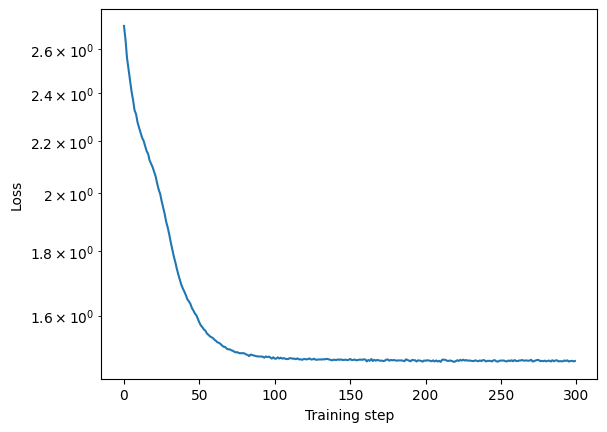

In [ ]:
print("Training on equation 3...")

mean_model_3  = MeanNet()
var_model_3   = VarNet()

optim_3 = torch.optim.Adam(
    list(mean_model_3.parameters()) +
    list(var_model_3.parameters()),
    lr=1e-3
)

loss_history_3 = train_loop(3, dataset, optim_3, mean_model=mean_model_3, var_model=var_model_3)
plt.plot(loss_history_3)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.show()

Training on equation 12...


  0%|          | 0/300 [00:00<?, ?it/s]

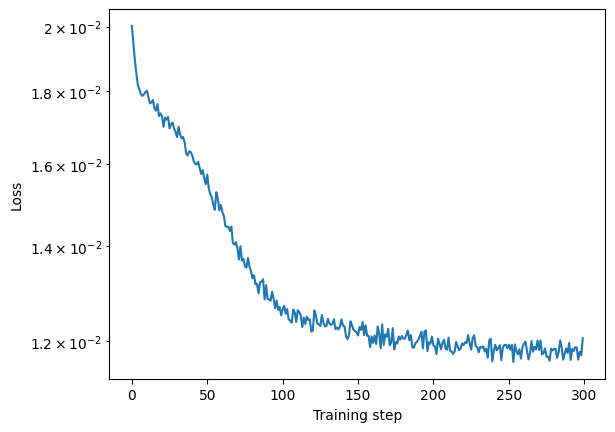

In [ ]:
print("Training on equation 12...")

noise_model_12 = NoiseNet()

optim_12 = torch.optim.Adam(
    list(noise_model_12.parameters()),
    lr=1e-3
)

loss_history_12 = train_loop(12, dataset, optim_12, noise_model=noise_model_12)
plt.plot(loss_history_12)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.show()

In [ ]:
def save_model(model, filepath):
    """
    Save the PyTorch model to a file.

    Args:
        model (torch.nn.Module): The PyTorch model to save.
        filepath (str): The path to save the model file.
    """
    torch.save(model.state_dict(), filepath)
    print("Model saved successfully.")

def load_model(model_class, filepath):
    """
    Load a PyTorch model from a file.

    Args:
        model_class (torch.nn.Module): The class of the PyTorch model to load.
        filepath (str): The path to the saved model file.

    Returns:
        model (torch.nn.Module): The loaded PyTorch model.
    """
    model_type = filepath.split("/")[-1].split("_")[0]
    #### ADD YOUR CODE HERE ####
    if model_type == "mean":
        model = MeanNet()
    elif model_type == "var":
        model =  VarNet()
    elif model_type == "noise":
        model = NoiseNet()
    else:
        raise ValueError("Invalid model type.")

    #### DONE WITH SOLUTION ####

    model.load_state_dict(torch.load(filepath), strict=False)
    model.eval()
    print("Model loaded successfully.")
    return model

In [ ]:
save_model(mean_model_3, "/content/hw2_GenAI/mean_model.pth")
save_model(var_model_3, "/content/hw2_GenAI/var_model.pth")
save_model(noise_model_12, "/content/hw2_GenAI/noise_model.pth")

In [ ]:
mean_model = load_model(torch.nn.Sequential, "/content/hw2_GenAI/mean_model.pth")
var_model = load_model(torch.nn.Sequential, "/content/hw2_GenAI/var_model.pth")
noise_model = load_model(torch.nn.Sequential, "/content/hw2_GenAI/noise_model.pth")

Model loaded successfully.
Model loaded successfully.
Model loaded successfully.


# Sampling
Implement the original paper's sampling procedure, for both equations 3,12

In [ ]:
def sample_reverse_equation3(mean_model, var_model, count, steps=TIME_STEPS):
    """
    Sample from the reverse process using equation 3
    :param mean_model: torch.nn.Module
    :param var_model: torch.nn.Module
    :param count: int
    :param steps: int
    :return: sample_history, a list of torch.Size([count, 1]) samples
    """
    #### ADD YOUR CODE HERE ####

    device = next(mean_model.parameters()).device
    x_t = torch.randn(count, 1, device=device)  # start from noise ~ N(0, I)
    sample_history = [x_t]

    for t in reversed(range(1, steps + 1)):
        t_tensor = torch.full((count, 1), t, dtype=torch.float, device=device)

        # Predict μ_θ and log σ²_θ from (x_t, t)
        mu_theta = mean_model(x_t, t_tensor)               # (count, 1)
        log_sigma2_theta = var_model(x_t, t_tensor)        # (count, 1)
        sigma_theta = torch.exp(0.5 * log_sigma2_theta)    # (count, 1)

        # Sample x_{t-1} ~ N(μ_θ, σ²_θ)
        noise = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)  # no noise at t=1→0
        x_t = mu_theta + sigma_theta * noise

        sample_history.append(x_t)

    #### DONE WITH SOLUTION ####
    return sample_history

def sample_reverse_equation12(noise_model, count, steps=TIME_STEPS):
    """
    Sample from the reverse process using equation 12
    :param noise_model: torch.nn.Module
    :param count: int
    :param steps: int
    :return: sample_history, a list of torch.Size([count, 1]) samples
    """
    #### ADD YOUR CODE HERE ####

    device = next(noise_model.parameters()).device
    x_t = torch.randn(count, 1, device=device)  # Start from x_T ~ N(0, I)
    sample_history = [x_t]

    beta = BETA
    alpha = 1.0 - beta
    sqrt_alpha = torch.sqrt(torch.tensor(alpha, device=device))

    for t in reversed(range(1, steps + 1)):
        t_tensor = torch.full((count, 1), t, dtype=torch.float, device=device)

        alpha_bar_t = torch.tensor(ALPHA_BAR[t], device=device)
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1. - alpha_bar_t)

        # Predict ε_θ(x_t, t)
        eps_theta = noise_model(x_t, t_tensor)

        # Compute mean μ_t using the closed-form from ε prediction
        coef1 = 1. / sqrt_alpha
        coef2 = (1. - alpha) / sqrt_one_minus_alpha_bar_t
        mu_t = coef1 * (x_t - coef2 * eps_theta)

        # Sample from N(μ_t, β_t I)
        sigma_t = torch.sqrt(torch.tensor(beta, device=device))
        noise = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
        x_t = mu_t + sigma_t * noise

        sample_history.append(x_t)

    #### DONE WITH SOLUTION ####

    return sample_history

In [ ]:
def sample_reverse(equation, mean_model, var_model, noise_model, count, steps=1000):
    """
    Sample from the reverse process using the given equation, it's a wrapper
    :param equation: int
    :param mean_model: Optional(torch.nn.Module)=None
    :param var_model: Optional(torch.nn.Module)=None
    :param noise_model: Optional(torch.nn.Module)=None
    :param count: int
    :param steps: int
    :return: sample_history, a list of torch.Size([count, 1]) samples
    """
    #### ADD YOUR CODE HERE ####

    if equation == 3:
        if mean_model is None or var_model is None:
            raise ValueError("Equation 3 requires both mean_model and var_model.")
        return sample_reverse_equation3(mean_model, var_model, count, steps)

    elif equation == 12:
        if noise_model is None:
            raise ValueError("Equation 12 requires noise_model.")
        return sample_reverse_equation12(noise_model, count, steps)

    else:
        raise NotImplementedError(f"Equation {equation} not supported. Choose 3 or 12.")


    #### DONE WITH SOLUTION ####

Show us your reverse sampling, x axis is time, y axis it the sampled process realization value.

Afterwards, compare the original distribution, with each of the estimated distributions, seperatly.

Add at the end of this section, where do you think the diffrence between the FIDs and the charts is coming from.

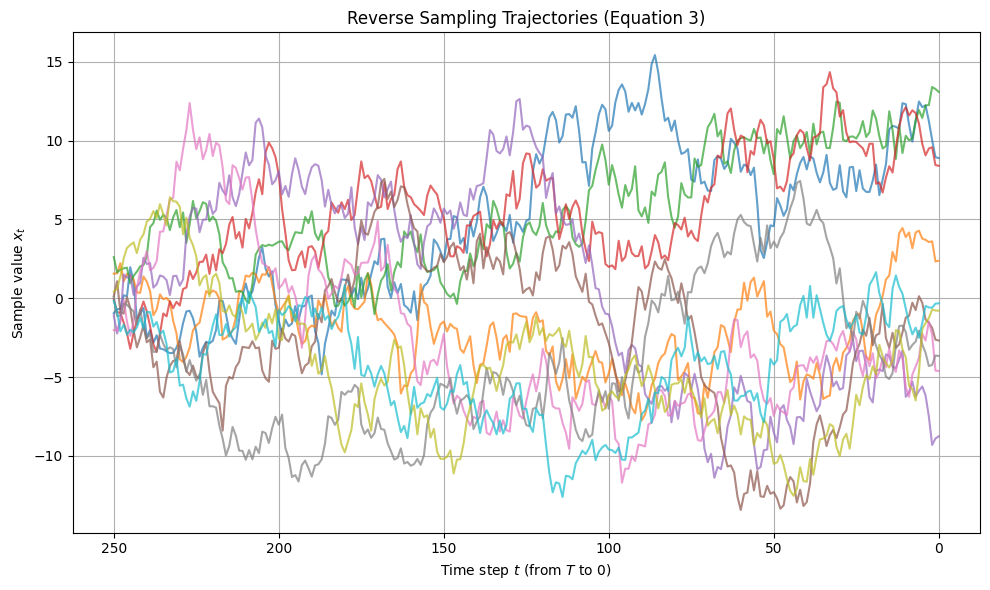

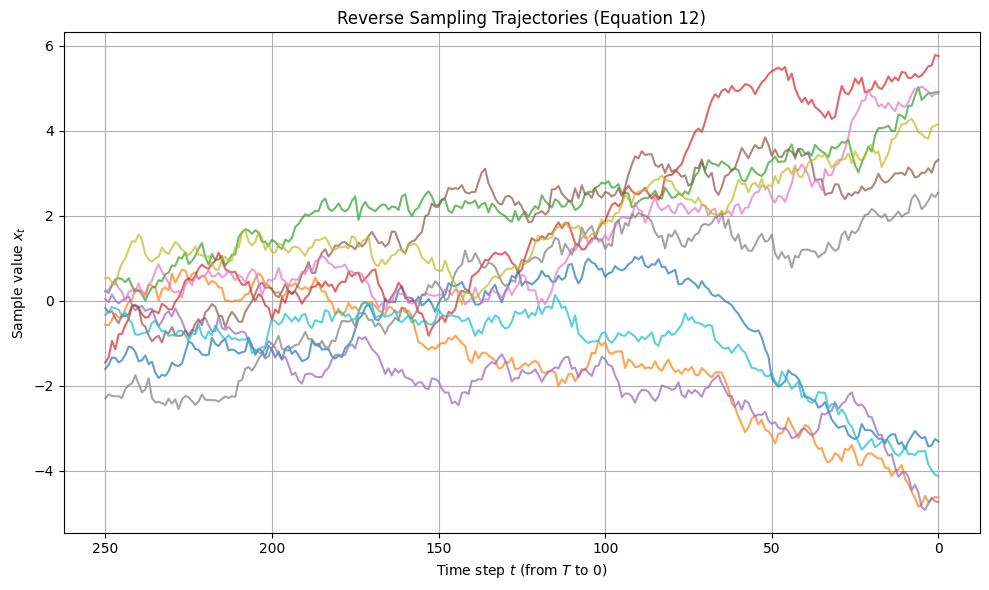

In [ ]:
#### ADD YOUR CODE HERE ####

import matplotlib.pyplot as plt
import torch

def plot_reverse_trajectories(equation, mean_model=None, var_model=None, noise_model=None, count=10, steps=TIME_STEPS):
    """
    Plot reverse sampling trajectories: x-axis = time, y-axis = sampled value
    """
    # 1. Generate reverse samples
    sample_history = sample_reverse(
        equation=equation,
        mean_model=mean_model,
        var_model=var_model,
        noise_model=noise_model,
        count=count,
        steps=steps
    )

    # 2. Stack and format
    all_steps = torch.stack(sample_history)              # (steps+1, count, 1)
    all_steps = all_steps.squeeze(-1).T.detach().cpu()   # (count, steps+1)

    all_steps = torch.flip(all_steps, dims=[1])          # Reverse it

    # 3. Plot trajectories
    plt.figure(figsize=(10, 6))
    for i in range(count):
        plt.plot(range(steps+1), all_steps[i], alpha=0.7)

    # 4. Invert X axis: left = T, right = 0
    plt.gca().invert_xaxis()

    plt.title(f"Reverse Sampling Trajectories (Equation {equation})")
    plt.xlabel("Time step $t$ (from $T$ to $0$)")
    plt.ylabel("Sample value $x_t$")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_reverse_trajectories(3, mean_model, var_model, None, count=10)
plot_reverse_trajectories(12, None, None, noise_model, count=10)

#### DONE WITH SOLUTION ####

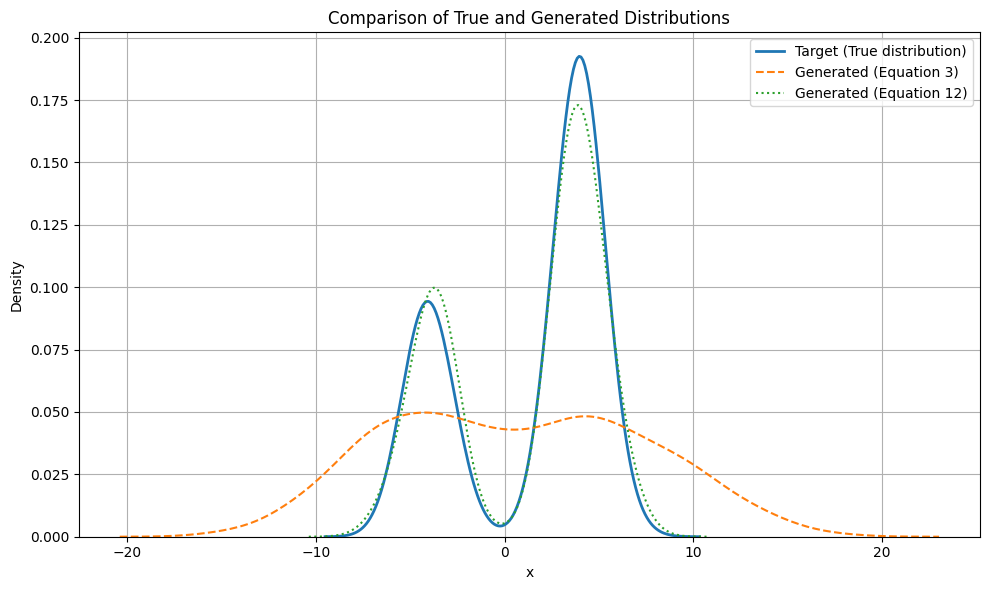

In [ ]:
#### ADD YOUR CODE HERE ####

def compare_generated_to_target(data_distribution, mean_model, var_model, noise_model, n_samples=1000):
    """
    Compare true distribution to samples from models trained with Eq 3 and Eq 12.
    """
    # 1. True distribution samples
    true_samples = data_distribution.sample(torch.Size([n_samples, 1])).cpu().numpy()

    # 2. Generated samples (Equation 3)
    gen_eq3 = sample_reverse_equation3(mean_model, var_model, n_samples)[-1]
    gen_eq3 = gen_eq3.detach().cpu().numpy()

    # 3. Generated samples (Equation 12)
    gen_eq12 = sample_reverse_equation12(noise_model, n_samples)[-1]
    gen_eq12 = gen_eq12.detach().cpu().numpy()

    # 4. Plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(true_samples.squeeze(), label="Target (True distribution)", linewidth=2)
    sns.kdeplot(gen_eq3.squeeze(), label="Generated (Equation 3)", linestyle='--')
    sns.kdeplot(gen_eq12.squeeze(), label="Generated (Equation 12)", linestyle=':')
    plt.title("Comparison of True and Generated Distributions")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_generated_to_target(data_distribution, mean_model, var_model, noise_model)


#### DONE WITH SOLUTION ####

In [ ]:
'''import numpy as np
from scipy.linalg import sqrtm

def compare_fid(data_distribution, mean_model, var_model, noise_model, count=10000):
    """
    Calculate the Frechet Inception Distance (FID) between the target distribution and the generated samples, uzilizing scipy.linalg.sqrtm
    :param data_distribution: torch.distributions.mixture_same_family.MixtureSameFamily
    :param mean_model: torch.nn.Module
    :param var_model: torch.nn.Module
    :param noise_model: torch.nn.Module
    :param count: int
    """

    original_samples = data_distribution.sample(torch.Size([10000, 1]))  # from your target distribution
    generated_samples_3 =  torch.stack(sample_reverse(3, mean_model, var_model, noise_model, 10000))[-1, :, 0] # from your trained model
    generated_samples_12 =  torch.stack(sample_reverse(12, mean_model, var_model, noise_model, 10000))[-1, :, 0] # from your trained model

    #### ADD YOUR CODE HERE ####


    #### DONE WITH SOLUTION ####


compare_fid(data_distribution, mean_model, var_model, noise_model, count=10000)'''

In [ ]:
import numpy as np
from scipy.linalg import sqrtm
import torch

@torch.no_grad()
def compare_fid(data_distribution, mean_model, var_model, noise_model, count=10000):
    """
    Efficiently compute the Frechet Inception Distance (FID) between the target distribution
    and generated samples from models trained with Eq. 3 and Eq. 12.
    Optimized to reduce memory usage.
    """

    # 1. True samples
    real_samples = data_distribution.sample(torch.Size([count, 1])).cpu().numpy()

    # 2. Final generated samples (x_0 only)
    x0_eq3 = sample_reverse(3, mean_model, var_model, noise_model, count, steps=TIME_STEPS)[-1]
    x0_eq12 = sample_reverse(12, mean_model, var_model, noise_model, count, steps=TIME_STEPS)[-1]


    fake_samples_3 = x0_eq3.detach().cpu().numpy().reshape(-1, 1)
    fake_samples_12 = x0_eq12.detach().cpu().numpy().reshape(-1, 1)

    def compute_fid(real, fake):
      real = real.reshape(-1, 1)
      fake = fake.reshape(-1, 1)

      mu_real = np.mean(real, axis=0)
      mu_fake = np.mean(fake, axis=0)

      sigma_real = np.atleast_2d(np.cov(real, rowvar=False))
      sigma_fake = np.atleast_2d(np.cov(fake, rowvar=False))

      covmean, _ = sqrtm(sigma_real @ sigma_fake, disp=False)
      if np.iscomplexobj(covmean):
          covmean = covmean.real

      fid = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * covmean)
      return fid


    # 3. Compute and print FID scores
    fid_eq3 = compute_fid(real_samples, fake_samples_3)
    fid_eq12 = compute_fid(real_samples, fake_samples_12)

    print(f"FID (Equation 3):  {fid_eq3:.4f}")
    print(f"FID (Equation 12): {fid_eq12:.4f}")

compare_fid(data_distribution, mean_model, var_model, noise_model)

FID (Equation 3):  8.6445
FID (Equation 12): 0.0076


**YOUR HYPOTHESIS REGARDING THE DIFFRENCE HERE**

The FID results, 8.64 for Equation 3 vs 0.0076 for Equation 12, and the visual distribution fitting, clearly show that the noise-prediction approach (Eq. 12) fits the target distribution significantly better than the full reverse-modeling approach (Eq. 3).

This difference may arise because Equation 12 simplifies the learning task, as discussed in class: instead of trying to model the full Gaussian reverse distribution with both mean and variance, it focuses solely on predicting the additive noise "epsilon". This reformulation transforms the problem into a simple regression task, which is much easier to optimize and less subject to overfitting or instability.

In contrast, Equation 3 requires accurate estimation of both the reverse mean and variance. Any mismatch in these estimations might decrease sample quality.

Intuitively, the epsilon formulation optimization problem aims to learn to detect the noise in a signal, which is exactly the intuition behind DDPM, as discussed in Tirgul 3.

## Section B

In this section, we will implement DDPM on multidimentional, unknown distribution.
Same as in previous section, will be based on the original DDPM paper by ([Ho et al., 2020](https://arxiv.org/abs/2006.11239))

In [4]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

### Network helpers

In [5]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    """
    simply adds the input to the output of a particular function
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Position embeddings

As the parameters of the neural network are shared across time (noise level), the authors employ sinusoidal position embeddings to encode $t$.


In [6]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Sinusoidal position embeddings, as described in the paper
    """

    def __init__(self, dim):
        """
        :param dim: int, the dimension of the embeddings
        """
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        :param time: torch Tenseor of shape (batch_size, 1)
        :return: torch Tensor of shape (batch_size, dim)
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet block

Next, we define the core building block of the U-Net model. The DDPM authors employed a Wide ResNet block.

In [7]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)


### Attention module

Next, we define the attention module, which the DDPM authors added in between the convolutional blocks.


In [8]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization

The DDPM authors interleave the convolutional/attention layers of the U-Net with group normalization.

In [9]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Conditional U-Net

Now that we've defined all building blocks (position embeddings, ResNet blocks, attention and group normalization), it's time to define the entire neural network. Recall that the job of the network $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$ is to take in a batch of noisy images + noise levels, and output the noise added to the input. More formally:

The network is built up as follows:
* first, a convolutional layer is applied on the batch of noisy images, and position embeddings are computed for the noise levels
* next, a sequence of downsampling stages are applied. Each downsampling stage consists of 2 ResNet blocks + groupnorm + attention (optionally linear) + residual connection + a downsample operation
* at the middle of the network, again ResNet blocks are applied, interleaved with attention
* next, a sequence of upsampling stages are applied. Each upsampling stage consists of 2 ResNet blocks + groupnorm + attention (optionally linear) + residual connection + an upsample operation
* finally, a ResNet block followed by a convolutional layer is applied.

Watch carefully every element of this architecture, what it is doing, which input shape and output shape it has.

In [10]:
class Unet(nn.Module):
    """
    Unet architecture for diffusion models
    the network takes a batch of noisy images of shape (batch_size, num_channels, height, width)
    and a batch of noise levels of shape (batch_size, 1) as input
    and returns a tensor of shape (batch_size, num_channels, height, width)
    """
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=1
    ):
        super().__init__()

        #### ADD YOUR CODE HERE ####

        self.channels = channels
        self.time_mlp = None

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.SiLU(),
                nn.Linear(time_dim, time_dim)
            )
        else:
            time_dim = None

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= len(in_out) - 1
            self.downs.append(nn.ModuleList([
                ResnetBlock(dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                ResnetBlock(dim_out, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else nn.Identity()
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)
            self.ups.append(nn.ModuleList([
                ResnetBlock(dim_out * 2, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                ResnetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else nn.Identity()
            ]))

        out_dim = default(out_dim, channels)
        self.final_block = ResnetBlock(dim, dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.final_conv = nn.Conv2d(dim, out_dim, 1)


        #### DONE WITH SOLUTION ####

    def forward(self, x, time):
        """
        :param x: torch Tensor of shape (batch_size, channels, height, width)
        :param time: torch Tensor of shape (batch_size, 1)
        :return: torch Tensor of shape (batch_size, channels, height, width)
        """

        #### ADD YOUR CODE HERE ####

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        x = self.init_conv(x)
        h = []

        # Downsampling path
        for res1, res2, attn, down in self.downs:
            x = res1(x, t)
            x = res2(x, t)
            x = attn(x)
            h.append(x)
            x = down(x)

        # Bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # Upsampling path
        for res1, res2, attn, up in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = res1(x, t)
            x = res2(x, t)
            x = attn(x)
            x = up(x)

        x = self.final_block(x, t)
        return self.final_conv(x)


        #### DONE WITH SOLUTION ####

## Defining the forward diffusion process

The forward diffusion process gradually adds noise to an image from the real distribution, in a number of time steps $T$, according to a **variance schedule**.

Implement both.

In [11]:
def linear_beta_schedule(timesteps):
    """
    set the forward process variances to constants
    increasing linearly from beta_1 = 0.0001 to beta_T = 0.02.
    :param timesteps: int
    :return: torch Tensor of shape (timesteps,)
    """
    #### ADD YOUR CODE HERE ####

    beta_start = 0.0001
    beta_end = 0.02

    #### DONE WITH SOLUTION ####
    return torch.linspace(beta_start, beta_end, timesteps)


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672))
    :param timesteps: int
    :param s: float
    :return: torch Tensor of shape (timesteps,)
    """
    #### ADD YOUR CODE HERE ####

    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]  # normalize

    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])

    #### DONE WITH SOLUTION ####
    return torch.clip(betas, 0.0001, 0.9999)


To start with, let's use the linear schedule for $T=200$ time steps.

Define the variables $\beta_t$, $\alpha_t$ for each $t$, the cumulative product of the variances $\bar{\alpha}_t$, and every other variable that is helpful.

Each should be a 1-dimensional tensors, storing values from $t$ to $T$. Later use the extract function to extract the appropriate $t$ index for a batch of indices.


In [12]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
#### ADD YOUR CODE HERE ####
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
#### DONE WITH SOLUTION ####

# calculations for diffusion q(x_t | x_{t-1}) and others
#### ADD YOUR CODE HERE ####
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
#### DONE WITH SOLUTION ####

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    # extracts the appropriate $t$ index for a batch of indices
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

From the DPPM paper:

> We assume that image data consists of integers in $\{0, 1, ... , 255\}$ scaled linearly to $[−1, 1]$. This
ensures that the neural network reverse process operates on consistently scaled inputs starting from
the standard normal prior $p(\mathbf{x}_T )$.

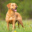

In [13]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import numpy as np
from PIL import Image
import requests

image_size = 32
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),

])

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

url = 'https://www.labradorsduparcdelormoy.com/wp-content/uploads/2021/10/un-labrador-jaune.jpg'
image = Image.open(requests.get(url, stream=True).raw)
x_start = transform(image).unsqueeze(0)
x_start.shape
reverse_transform(x_start.squeeze())

### Forward/ Diffusion process ###

In [14]:
# forward diffusion q(x_t | x_0)
def q_sample(x_start, t, noise=None):
    """
    q_sample function for diffusion process
    :param x_start: torch Tensor of shape (batch_size, channels, height, width)
    :param t: torch Tensor of shape (batch_size, 1)
    :param noise: Optional(torch.Tensor) = None
    :return: torch Tensor of shape (batch_size, channels, height, width)
    """
    #### ADD YOUR CODE HERE ####

    if noise is None:
        noise = torch.randn_like(x_start)

    # extract sqrt_alpha_cumprod and sqrt_one_minus_alpha_cumprod for each t in the batch
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    # return the noisy image
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    #### DONE WITH SOLUTION ####

Test your result on a particular time step:

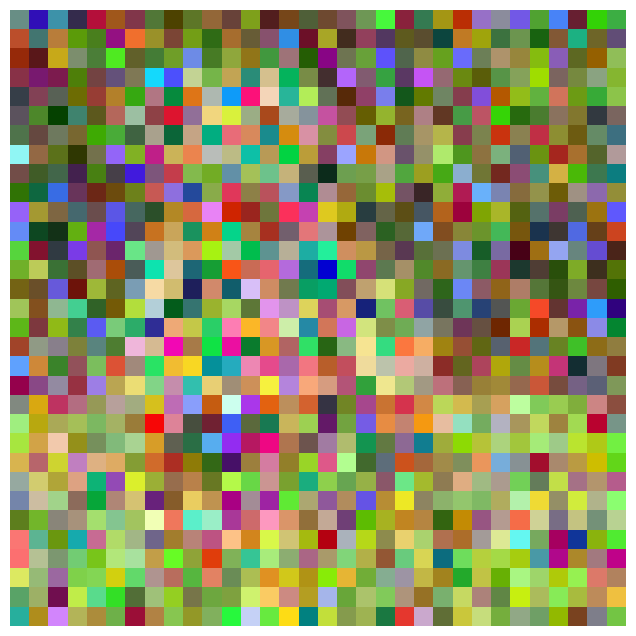

In [15]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

#### ADD YOUR CODE HERE ####

# pick a timestep
t = torch.tensor([50])  # single timestep for batch size 1

# make sure x_start is a single image of shape (1, 3, H, W)
assert x_start.shape[0] == 1

# generate and show the noisy image
img = get_noisy_image(x_start, t)

from IPython.display import display

def show_large_image(img, size=6):
    """
    Display a PIL image with a larger figure size.
    :param img: PIL.Image
    :param size: Size in inches (default: 6)
    """
    plt.figure(figsize=(size, size))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Show image
show_large_image(img, size=8)

#### DONE WITH SOLUTION ####

Now visualize this for various time steps:

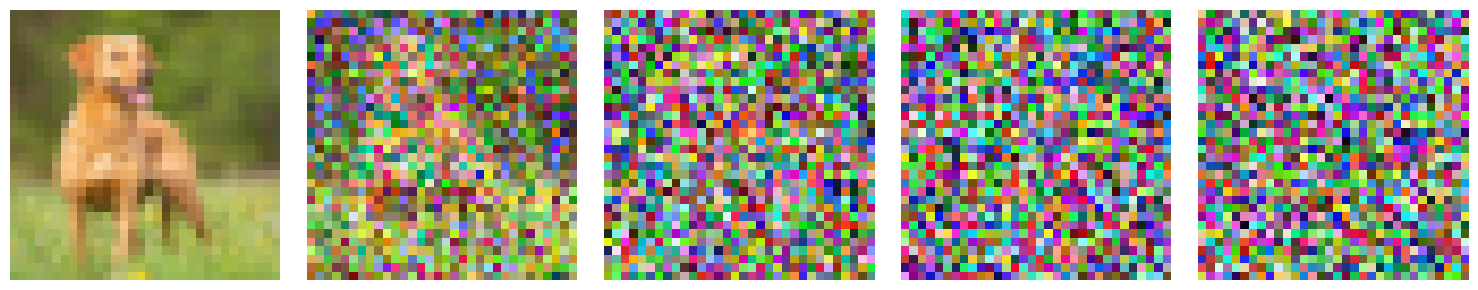

In [16]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

#### ADD YOUR CODE HERE ####
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    """
    Plot a list of images in a grid.
    :param imgs: list of images to plot
    :param with_orig: bool, whether to include the original image
    :param row_title: list of titles for each row
    :param imshow_kwargs: additional arguments for imshow
    """

    num_imgs = len(imgs)
    plt.figure(figsize=(3 * num_imgs, 3))

    for idx, img in enumerate(imgs):
        plt.subplot(1, num_imgs, idx + 1)
        plt.imshow(img, **imshow_kwargs)
        plt.axis('off')
        if row_title:
            plt.title(row_title[idx], fontsize=12)

    plt.tight_layout()
    plt.show()

#### DONE WITH SOLUTION ####

plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])


Define the loss function given the model. Use the U-Net defined above.


In [17]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    #### ADD YOUR CODE HERE ####

    # sample x_t from q(x_t | x_0)
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)

    # predict noise using model
    predicted_noise = denoise_model(x_noisy, t)

    #### DONE WITH SOLUTION ####

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## Define a PyTorch Dataset + DataLoader

The dataset is Fashion-MNIST, to easily load the Fashion MNIST dataset from the [hub](https://huggingface.co/datasets/fashion_mnist).
The images suppose to be 28x28 grayscale images, scaled linearly to $[-1, 1]$.

Implement a PyTorch Dataset class that loads the images and applies wanted transformations on-the-fly, and a DataLoader to load the dataset in batches.


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.68MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.9MB/s]


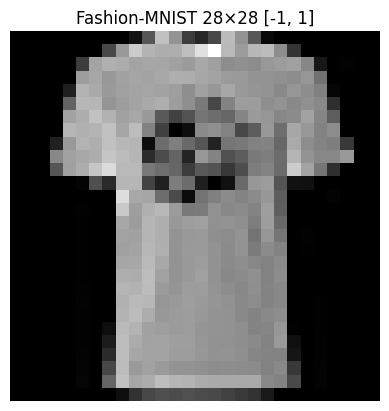

In [ ]:
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import FashionMNIST

#### ADD YOUR CODE HERE ####

# ──────────────── Transformations ────────────────

transform = Compose([
    ToTensor(),                            # (H, W, C) → (C, H, W), values in [0, 1]
    Lambda(lambda t: (t * 2) - 1)          # [0, 1] → [-1, 1]
])

reverse_transform = Compose([
    Lambda(lambda t: (t + 1) / 2),         # [-1, 1] → [0, 1]
    Lambda(lambda t: t.permute(1, 2, 0)),  # CHW → HWC
    Lambda(lambda t: t * 255.),
    Lambda(lambda t: t.numpy().astype(np.uint8)),
    ToPILImage()
])

# ──────────────── Dataset class ────────────────

class FashionMNIST28(Dataset):
    def __init__(self, root='./data', train=True, transform=None, download=True):
        self.dataset = FashionMNIST(root=root, train=train, transform=transform, download=download)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # Ignore label
        return img

# ──────────────── DataLoader ────────────────

batch_size = 64

train_dataset = FashionMNIST28(transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# ──────────────── Sanity check ────────────────

for batch in train_loader:
    img_tensor = batch[0]  # Shape: (1, 28, 28)
    pil_img = reverse_transform(img_tensor)
    plt.imshow(pil_img, cmap='gray')
    plt.axis('off')
    plt.title("Fashion-MNIST 28×28 [-1, 1]")
    plt.show()
    break

#### DONE WITH SOLUTION ####


## Sampling

Implement sampling algorithm 2 from the original paper:

![Sampling.png](attachment:Sampling.png)

In [ ]:

@torch.no_grad()
def p_sample(model, x, t, t_index):
    """
    p_sample function for reverse process
    :param model: torch.nn.Module
    :param x: torch Tensor of shape (batch_size, channels, height, width)
    :param t: torch Tensor of shape (batch_size, 1)
    :param t_index: int
    :return: torch Tensor of shape (batch_size, channels, height, width)
    """
    #### ADD YOUR CODE HERE ####

    # predict noise with the model
    predicted_noise = model(x, t)

    # extract required coefficients
    alpha_t = extract(alphas, t, x.shape)
    sqrt_one_minus_alpha_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alpha_t = extract(sqrt_recip_alphas, t, x.shape)
    beta_t = extract(betas, t, x.shape)

    # compute model mean (posterior mean from DDPM paper)
    model_mean = sqrt_recip_alpha_t * (
        x - (beta_t / sqrt_one_minus_alpha_cumprod_t) * predicted_noise
    )


    #### DONE WITH SOLUTION ####

    if t_index == 0:
        return model_mean
    else:
        #### ADD YOUR CODE HERE ####

        noise = torch.randn_like(x)
        sigma_t = torch.sqrt(beta_t)
        return model_mean + sigma_t * noise

        #### DONE WITH SOLUTION ####


# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))



## Train the model

Implement training algorithm 1 from the original paper:

![Training.png](attachment:Training.png)

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=28,
    channels=1,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
from torchvision.utils import save_image
from pathlib import Path

#### ADD YOUR CODE HERE ####

# ─────────────── Setup ───────────────

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=28,                   # since Fashion-MNIST is 28x28
    channels=1,               # grayscale images
    dim_mults=(1, 2, 4)       # 28 → 14 → 7 → bottleneck
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

# ─────────────── Training Loop ───────────────

epochs = 20
global_step = 0

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    for x_start in tqdm(train_loader):
        model.train()
        x_start = x_start.to(device)

        # Step 2: Sample timestep t ~ Uniform({1,...,T})
        t = torch.randint(0, timesteps, (x_start.shape[0],), device=device).long()

        # Step 3-5: compute noise loss and take gradient step
        loss = p_losses(model, x_start, t, loss_type="l2")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        global_step += 1

#### DONE WITH SOLUTION ####

Epoch 1/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 2/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 3/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 4/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 5/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 6/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 7/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 8/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 9/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 10/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 11/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 12/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 13/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 14/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 15/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 16/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 17/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 18/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 19/20


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 20/20


  0%|          | 0/937 [00:00<?, ?it/s]

In [ ]:
# Save final model after all epochs
final_model_path = "/content/ddpm_final.pt"

torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")

Final model saved to /content/ddpm_final.pt


In [ ]:
# load model

# Rebuild the same model architecture
model = Unet(
    dim=28,
    channels=1,
    dim_mults=(1, 2, 4)
)
model.load_state_dict(torch.load("/content/ddpm_final.pt", map_location=device))
model.to(device)
model.eval()  # eval mode for sampling. Meragech


Unet(
  (init_conv): Conv2d(1, 28, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): SiLU()
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=28, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(1, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(1, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2): Residual(
        (fn): PreNorm(
          (fn): Li

# Sampling (inference)

To sample from the model, you can just use the sample function defined above.

### Sample at least 64 images for submission.

### The zip file should follow the format "HW\{\#assignment\}\_\{id\}.\{extension\}" (according to the course syllabus).

### Images within the zip should be .png or .jpg.


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

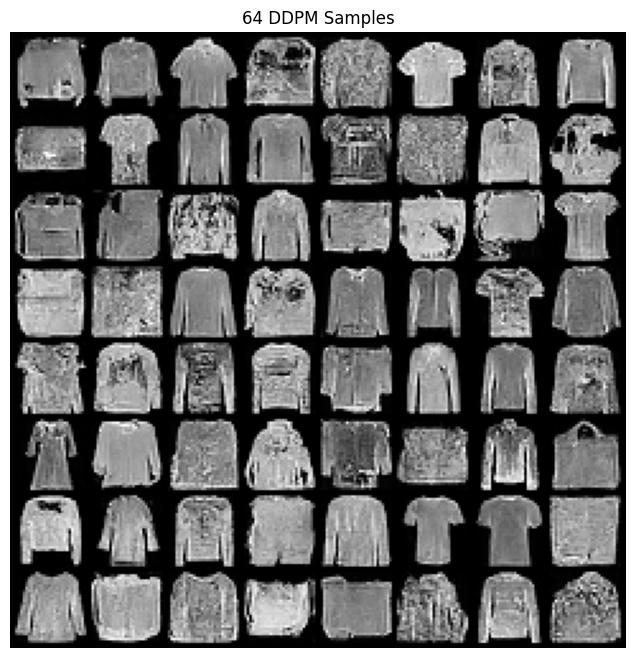

In [ ]:
from torchvision.utils import make_grid

# sample 64 images
samples = sample(model, image_size=28, batch_size=64, channels=1)

#### ADD YOUR CODE HERE ####

# Step 2: take final x_0 sample and convert to tensor
final_sample = torch.tensor(samples[-1])  # shape (64, 1, 28, 28)
final_sample = (final_sample + 1) / 2     # scale from [-1,1] → [0,1]

# Step 3: create grid
grid = make_grid(final_sample, nrow=8)

# Step 4: show using matplotlib
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title("64 DDPM Samples")
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.show()


#### DONE WITH SOLUTION ####

Run the following code to show us the denoising process
Or Create an animation of the denoising process - for a specific sample <random_index>:

In [ ]:
import imageio
import numpy as np
from torchvision.transforms import ToPILImage
import torch
from IPython.display import Image as IPyImage, display

to_pil = ToPILImage()

random_index = 53
frames = []

for i in range(timesteps):
    img_array = samples[i][random_index]  # assumed shape [C, H, W]

    if isinstance(img_array, np.ndarray):
        img_array = (img_array + 1) / 2
        img_array = np.clip(img_array, 0, 1)
        img_tensor = torch.from_numpy(img_array)
    else:
        img_tensor = (img_array + 1) / 2
        img_tensor = img_tensor.clamp(0, 1)

    img = to_pil(img_tensor)
    frames.append(np.array(img))

gif_path = "diffusion.gif"
imageio.mimsave(gif_path, frames, duration=0.05)

display(IPyImage(filename="diffusion.gif", width=512, height=512))

### The code file should follow the format "HW\{\#assignment\}\_\{id\}.\{extension\}" (according to the course syllabus).
